In [580]:
import pandas as pd

load_frame = pd.read_csv('corn_not_corn%.csv',dtype={'year':int})
load_frame.index = pd.to_datetime(load_frame['year'],format='%Y')

In [581]:
load_frame = load_frame.drop(['Unnamed: 0','year'],axis =1)

In [582]:
corn_frame = pd.DataFrame(index=load_frame.index.unique(),columns=load_frame['county_name'].unique())

In [583]:
print(load_frame)

           county_name commodity_desc     value   percent
year                                                     
1919-01-01      DICKEY           CORN   31000.0  0.093373
1919-01-01      DICKEY       NOT CORN  301000.0  0.906627
1919-01-01    LA MOURE           CORN   18000.0  0.046997
1919-01-01    LA MOURE       NOT CORN  365000.0  0.953003
1919-01-01       LOGAN           CORN    2000.0  0.009524
...                ...            ...       ...       ...
2020-01-01    LA MOURE       NOT CORN  210570.0  0.774667
2020-01-01       LOGAN           CORN   28220.0  0.166588
2020-01-01       LOGAN       NOT CORN  141180.0  0.833412
2020-01-01    MCINTOSH           CORN   39280.0  0.175986
2020-01-01    MCINTOSH       NOT CORN  183920.0  0.824014

[802 rows x 4 columns]


In [584]:
load_frame_perc = load_frame[load_frame['commodity_desc']=='CORN'][['county_name','value']]

In [585]:
for county in corn_frame.columns:
    corn_frame[county] = load_frame_perc[load_frame_perc['county_name'] == county]['value']

In [586]:
corn_not_corn = pd.DataFrame(index=load_frame.index.unique(),columns=load_frame[load_frame['county_name'] == 'DICKEY']['commodity_desc'].unique())

In [587]:
logan_frame = load_frame[load_frame['county_name'] == 'LOGAN']
logan_frame = logan_frame.drop(columns=['county_name','percent'])

In [588]:
print(logan_frame)

           commodity_desc     value
year                               
1919-01-01           CORN    2000.0
1919-01-01       NOT CORN  208000.0
1920-01-01           CORN    4000.0
1920-01-01       NOT CORN  218000.0
1921-01-01           CORN    7000.0
...                   ...       ...
2017-01-01       NOT CORN  163110.0
2018-01-01       NOT CORN   53300.0
2019-01-01       NOT CORN   43200.0
2020-01-01           CORN   28220.0
2020-01-01       NOT CORN  141180.0

[199 rows x 2 columns]


In [589]:
for col in corn_not_corn.columns:
    corn_not_corn[col] = logan_frame[logan_frame['commodity_desc'] == col]['value']

In [590]:
corn_not_corn = corn_not_corn.interpolate()

In [591]:
corn_frame = corn_frame.interpolate()

In [592]:
from statsmodels.tsa.vector_ar.var_model import VAR
from matplotlib import pyplot as plt

train = corn_frame[:76]
valid = corn_frame[76:82]

model = VAR(endog=train)
model_fit = model.fit(6)
prediction = model_fit.forecast(model_fit.endog,steps=len(valid))

pred = pd.DataFrame(prediction,index=corn_frame.index[76:82],columns=corn_frame.columns)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


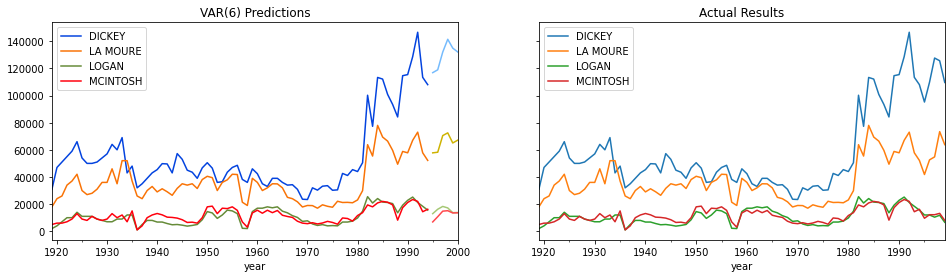

In [605]:
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

fig, ax = plt.subplots(1,2,sharey=True,figsize=(16,4))
ax[0].set_title('VAR(6) Predictions')
train.plot(color={'DICKEY':'xkcd:blue','LA MOURE':'xkcd:orange','LOGAN':'xkcd:moss green','MCINTOSH':'xkcd:bright red'},ax=ax[0])
pred.plot(ax=ax[0],color={'DICKEY':'xkcd:sky blue','LA MOURE':'xkcd:mustard','LOGAN':'xkcd:light moss green','MCINTOSH':'xkcd:light red'},legend=False)
#plt.savefig('VAR Predictions.png')

corn_frame[:81].plot(ax = ax[1])
plt.title('Actual Results')
plt.savefig('VARsidebyside.png')
plt.show()

In [607]:
'''corn_frame[:81].plot()
plt.title('Actual Results')
plt.savefig('4countyactual.png')'''
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 16, Apr, 2021
Time:                     01:22:45
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    70.7031
Nobs:                     70.0000    HQIC:                   68.7669
Log likelihood:          -2659.49    FPE:                2.33439e+29
AIC:                      67.4910    Det(Omega_mle):     6.88132e+28
--------------------------------------------------------------------
Results for equation DICKEY
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const            5023.162948      5916.278440            0.849           0.396
L1.DICKEY           0.862282         0.279556            3.084           0.002
L1.LA MOURE        -0.431770         0.414256           -1.042     

In [ ]:
#5-year MSE for q=6:
print(np.sqrt(((valid - pred).sum()**2).sum()/(6)))

In [ ]:
train = corn_frame[:76]
valid = corn_frame[76:82]

model = VAR(endog=train)
model_fit = model.fit(2)
prediction = model_fit.forecast(model_fit.endog,steps=len(valid))

pred = pd.DataFrame(prediction,index=corn_frame.index[76:82],columns=corn_frame.columns)
print(np.sqrt(((valid - pred).sum()**2).sum()/(6)))

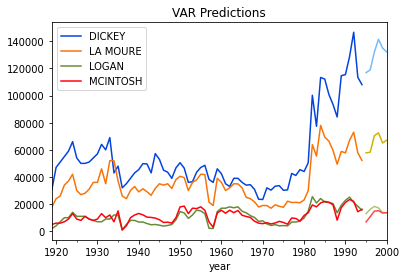

In [608]:
ax = train.plot(color={'DICKEY':'xkcd:blue','LA MOURE':'xkcd:orange','LOGAN':'xkcd:moss green','MCINTOSH':'xkcd:bright red'})
pred.plot(ax=ax,color={'DICKEY':'xkcd:sky blue','LA MOURE':'xkcd:mustard','LOGAN':'xkcd:light moss green','MCINTOSH':'xkcd:light red'},legend=False)
plt.title('VAR Predictions')
plt.savefig('VAR Predictions.png')
plt.show()

In [609]:
time_range = np.arange(76,82)
RMSEs = []
for k in time_range:
    train = corn_frame[:k]
    valid = corn_frame[k:k+1]

    model = VAR(endog=train)
    model_fit = model.fit(2)
    prediction = model_fit.forecast(model_fit.endog,steps=1)

    pred = pd.DataFrame(prediction,index=corn_frame.index[k:k+1],columns=corn_frame.columns)

    RMSEs += [np.sqrt(((valid - pred).sum()**2).sum())]

print(np.mean(RMSEs))

28991.732722746598


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local

In [610]:
time_range = np.arange(76,82)
RMSEs = []
for k in time_range:
    train = corn_frame[:k]
    valid = corn_frame[k:k+1]

    model = VAR(endog=train)
    model_fit = model.fit(6)
    prediction = model_fit.forecast(model_fit.endog,steps=1)

    pred = pd.DataFrame(prediction,index=corn_frame.index[k:k+1],columns=corn_frame.columns)

    RMSEs += [np.sqrt(((valid - pred).sum()**2).sum())]

print(np.mean(RMSEs))

30142.89603245817


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                                      DICKEY  ...      MCINTOSH
2021-01-01 00:00:00.000000000   95275.585926  ...  30164.163501
2022-01-01 05:08:34.285714284   69978.965756  ...  30490.944818
2023-01-01 10:17:08.571428568   59515.221631  ...  39381.243262
2024-01-01 15:25:42.857142848  120096.684536  ...  38344.469753
2024-12-31 20:34:17.142857136  168193.879484  ...  34577.046252
2026-01-01 01:42:51.428571424   89102.549470  ...  20170.174379
2027-01-01 06:51:25.714285696   59886.545891  ...   9685.100173
2028-01-01 12:00:00.000000000   55952.685928  ...  11149.878499
2028-12-31 17:08:34.285714272   85880.052243  ...  18327.735795
2029-12-31 22:17:08.571428544   56604.266130  ...  31703.924197
2031-01-01 03:25:42.857142848   34166.977168  ...  24185.941538
2032-01-01 08:34:17.142857152   32799.550307  ...  24146.599596
2032-12-31 13:42:51.428571392   58078.881117  ...  34881.740745
2033-12-31 18:51:25.714285696   55481.332613  ...  26248.243372
2035-01-01 00:00:00.000000000   52529.51

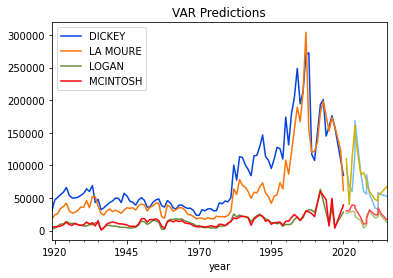

In [633]:
train = corn_frame

model = VAR(endog=train)
model_fit = model.fit(6)
prediction = model_fit.forecast(model_fit.endog,steps=15)

pred = pd.DataFrame(prediction,index=pd.date_range("1-1-2021", "1-1-2035",periods=15), columns=corn_frame.columns)

print(pred)

ax = train.plot(color={'DICKEY':'xkcd:blue','LA MOURE':'xkcd:orange','LOGAN':'xkcd:moss green','MCINTOSH':'xkcd:bright red'})
pred.plot(ax=ax,color={'DICKEY':'xkcd:sky blue','LA MOURE':'xkcd:mustard','LOGAN':'xkcd:light moss green','MCINTOSH':'xkcd:light red'},legend=False)
plt.title('VAR Predictions')
plt.savefig('Future Predictions.png')
plt.show()